In [ ]:
import os
import random
import numpy as np
from collections import Counter
import seaborn as sns
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader, random_split, Subset, WeightedRandomSampler
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, models
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import os
import time
import copy
from PIL import ImageFile, Image
import warnings
warnings.filterwarnings('ignore')

ImageFile.LOAD_TRUNCATED_IMAGES = True

randomSeed = 42
random.seed(randomSeed)
np.random.seed(randomSeed)
torch.manual_seed(randomSeed)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device: {device}")

Device: cpu


In [32]:
trainTransform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.02),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])
testTransform = transforms.Compose([
    transforms.Resize(int(224*1.14)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485,0.456,0.406], std=[0.229,0.224,0.225])
])

Размер полного датасета: 1649
Классы: ['belka_finlay', 'belka_karoling', 'deppe', 'gimalay_belka', 'prevost']


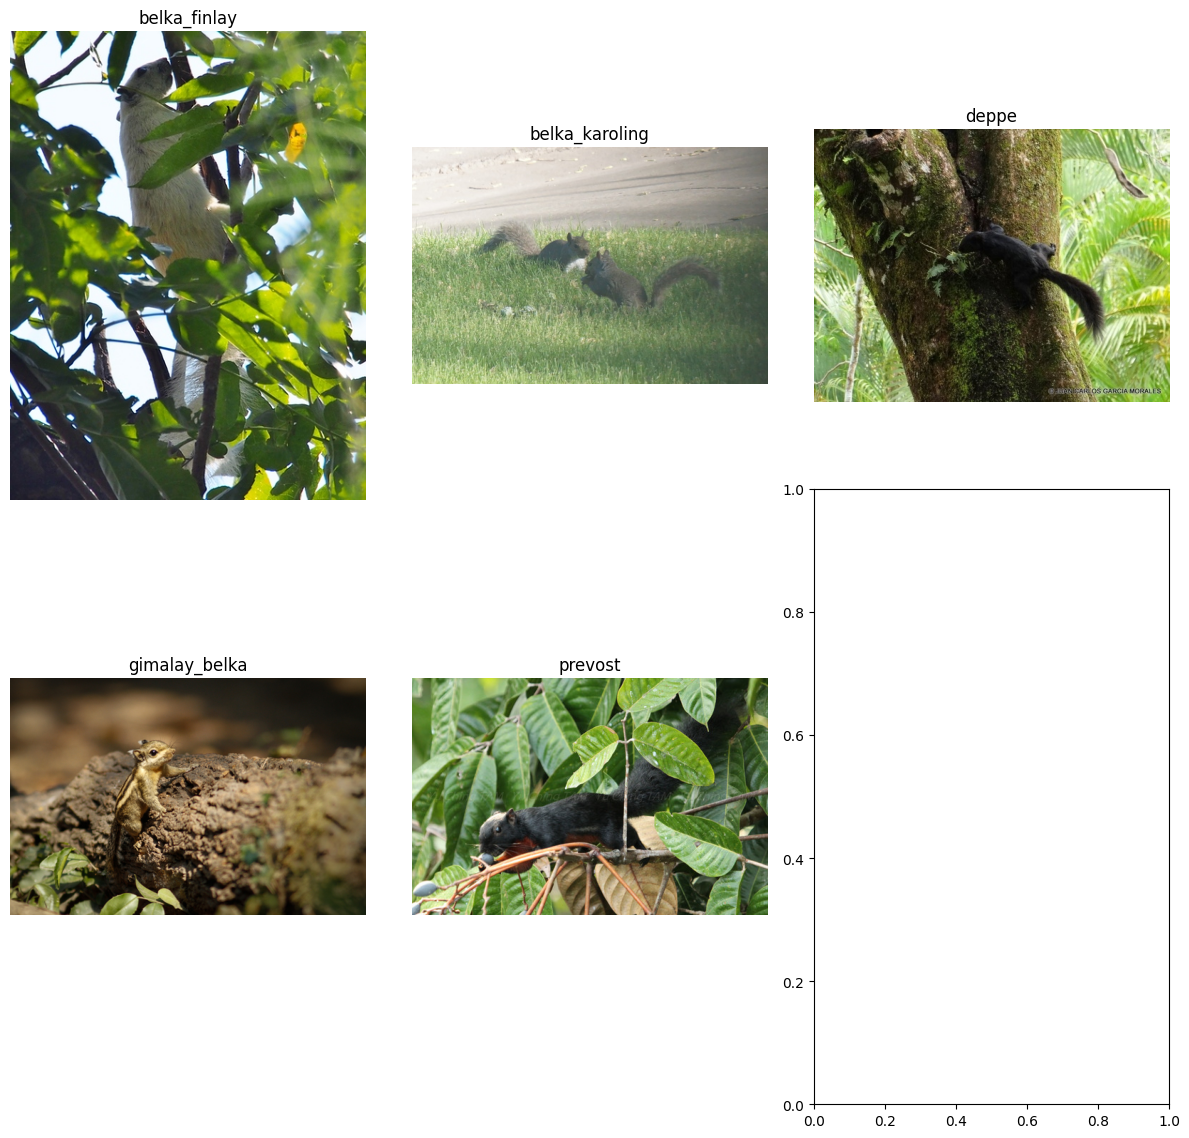

In [33]:
Directory = './squirrel'

fullDataset = datasets.ImageFolder(Directory, transform=trainTransform)
numClasses = len(fullDataset.classes)

imagesPerClass = {}
for path, label in fullDataset.samples:
    if label not in imagesPerClass:
        imagesPerClass[label] = path
    if len(imagesPerClass) == numClasses:
        break

print("Размер полного датасета:", len(fullDataset))
print("Классы:", fullDataset.classes)

fig, axes = plt.subplots(2, 3, figsize=(12, 12))
axes = axes.ravel()

for idx, (label, imgPath) in enumerate(imagesPerClass.items()):
    imgObject = Image.open(imgPath)
    axes[idx].imshow(imgObject)
    axes[idx].set_title(fullDataset.classes[label], fontsize=12)
    axes[idx].axis('off')

plt.tight_layout()
plt.show()

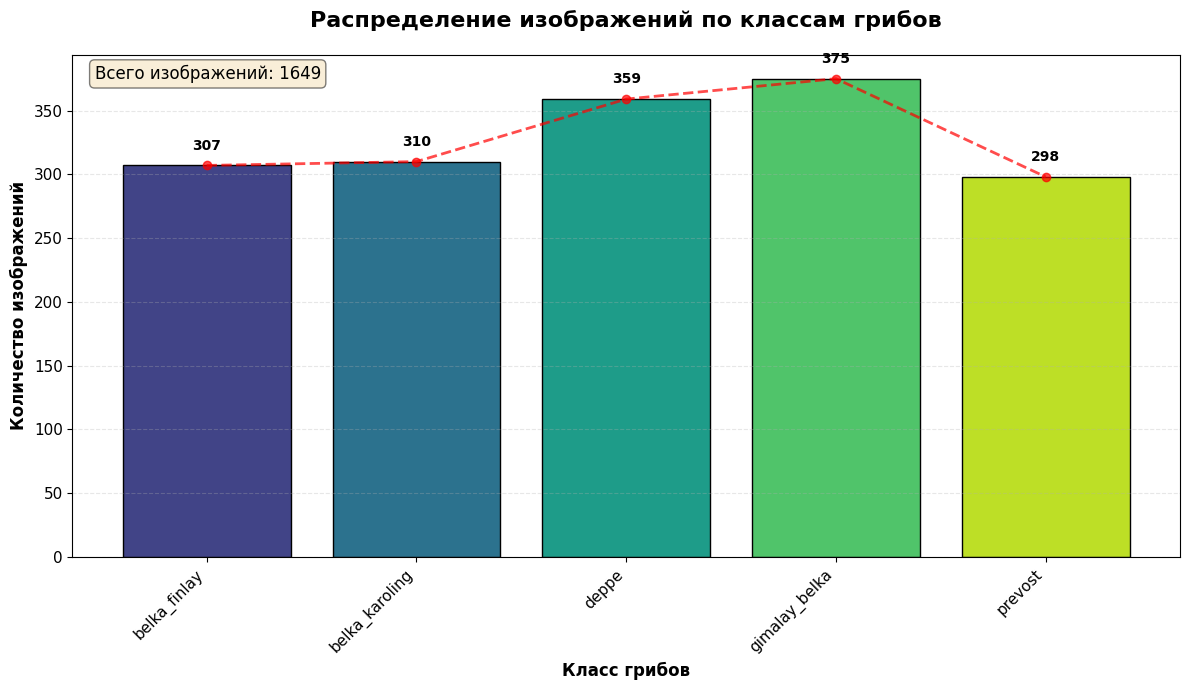

СТАТИСТИКА ДАТАСЕТА
       class_name  count
0    belka_finlay    307
1  belka_karoling    310
2           deppe    359
3   gimalay_belka    375
4         prevost    298

Всего классов: 5
Всего изображений: 1649
Минимальное количество в классе: 298
Максимальное количество в классе: 375
Среднее количество на класс: 329.8
Медианное количество: 310.0


In [34]:
classCounts = Counter([label for _, label in fullDataset.samples])
countDf = pd.DataFrame.from_dict(classCounts, orient='index', columns=['count']).sort_values('count', ascending=False)
countDf['class_name'] = [fullDataset.classes[i] for i in countDf.index]

countDf = countDf.sort_values('class_name')  

plt.figure(figsize=(12, 7))

bars = plt.bar(countDf['class_name'], countDf['count'], 
               color=plt.cm.viridis(np.linspace(0.2, 0.9, len(countDf))),
               edgecolor='black', linewidth=1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 10,
             f'{int(height)}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.plot(countDf['class_name'], countDf['count'], 
         color='red', linestyle='--', linewidth=2, alpha=0.7, marker='o')

plt.title('Распределение изображений по классам грибов', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Класс грибов', fontsize=12, fontweight='bold')
plt.ylabel('Количество изображений', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)

plt.grid(True, axis='y', alpha=0.3, linestyle='--')

total_images = countDf['count'].sum()
plt.text(0.02, 0.98, f'Всего изображений: {total_images}', 
         transform=plt.gca().transAxes, fontsize=12, 
         verticalalignment='top', bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.show()

# Выводим статистику
print("="*50)
print("СТАТИСТИКА ДАТАСЕТА")
print("="*50)
print(countDf[['class_name', 'count']])
print("\n" + "="*50)
print(f"Всего классов: {len(countDf)}")
print(f"Всего изображений: {total_images}")
print(f"Минимальное количество в классе: {countDf['count'].min()}")
print(f"Максимальное количество в классе: {countDf['count'].max()}")
print(f"Среднее количество на класс: {countDf['count'].mean():.1f}")
print(f"Медианное количество: {countDf['count'].median()}")
print("="*50)

In [35]:

from sklearn.model_selection import train_test_split




def getSquirrelDataLoaders(
    data_dir: str = './data',
    test_size: float = 0.2,
    batch_size: int = 32,
    random_state: int = 42,
    workers: int = 0
):
  
    full_dataset = datasets.ImageFolder(data_dir)
    
    all_labels = [label for _, label in full_dataset.samples]
    
    train_indices, test_indices = train_test_split(
        range(len(full_dataset)),
        test_size=test_size,
        random_state=random_state,
        stratify=all_labels
    )
    
 
    train_dataset = Subset(
        datasets.ImageFolder(data_dir, transform=trainTransform),
        train_indices
    )
    
    test_dataset = Subset(
        datasets.ImageFolder(data_dir, transform=testTransform), 
        test_indices
    )
    
    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,  
        num_workers=workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    
    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,  
        num_workers=workers,
        pin_memory=True if torch.cuda.is_available() else False
    )
    

    print(f"Classes found: {full_dataset.classes}")
    print(f"Class to index mapping: {full_dataset.class_to_idx}")
    print(f"Total samples: {len(full_dataset)}")
    print(f"Training samples: {len(train_dataset)}")
    print(f"Test samples: {len(test_dataset)}")
    print(f"Training batches: {len(train_loader)}")
    print(f"Test batches: {len(test_loader)}")
    
    return train_loader, test_loader, train_dataset, test_dataset

In [36]:
trainLoader, testLoader, trainDataset, testDataset = getSquirrelDataLoaders(data_dir=Directory,test_size=0.2, batch_size=32, workers=2)



batchFeatures, batchLabels = next(iter(trainLoader))
print(f"Batch features shape: {batchFeatures.shape}, labels shape: {batchLabels.shape}")

Classes found: ['belka_finlay', 'belka_karoling', 'deppe', 'gimalay_belka', 'prevost']
Class to index mapping: {'belka_finlay': 0, 'belka_karoling': 1, 'deppe': 2, 'gimalay_belka': 3, 'prevost': 4}
Total samples: 1649
Training samples: 1319
Test samples: 330
Training batches: 42
Test batches: 11


Exception ignored while calling deallocator <function _MultiProcessingDataLoaderIter.__del__ at 0x11d0b8d50>:
Traceback (most recent call last):
  File "/Users/browka/Documents/firstone/venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/Users/browka/Documents/firstone/venv/lib/python3.14/site-packages/torch/utils/data/dataloader.py", line 1618, in _shutdown_workers
    w.join(timeout=_utils.MP_STATUS_CHECK_INTERVAL)
  File "/opt/homebrew/Cellar/python@3.14/3.14.2/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/process.py", line 156, in join
    res = self._popen.wait(timeout)
  File "/opt/homebrew/Cellar/python@3.14/3.14.2/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessing/popen_fork.py", line 41, in wait
    if not wait([self.sentinel], timeout):
  File "/opt/homebrew/Cellar/python@3.14/3.14.2/Frameworks/Python.framework/Versions/3.14/lib/python3.14/multiprocessin

Batch features shape: torch.Size([32, 3, 224, 224]), labels shape: torch.Size([32])


In [ ]:
class SquirrelCNN(nn.Module):    
    def __init__(self, num_classes=5):
        super(SquirrelCNN, self).__init__()
        
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.Conv2d(32, 32, 3, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(32, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, 3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(64, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.Conv2d(128, 128, 3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
            
            nn.Conv2d(128, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, 3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(2, 2),
            nn.Dropout2d(0.25),
        )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(256 * 14 * 14, 512),  
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.ReLU(inplace=True),
            nn.Dropout(0.3),
            nn.Linear(256, num_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x
    
    def get_summary(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        
        print(f" Всего параметров: {total_params:,}")
        print(f" Обучаемых параметров: {trainable_params:,}")
        print(f"Архитектура:")
        
        for name, module in self.named_children():
            print(f"  {name}: {module}")

In [ ]:
#EfficientNetB0 модель
class SquirrelEfficientNet(nn.Module):
    
    def __init__(self, num_classes=5, pretrained=True):
        super(SquirrelEfficientNet, self).__init__()
        
        self.efficientnet = models.efficientnet_b0(pretrained=pretrained)
        
        for param in self.efficientnet.parameters():
            param.requires_grad = False
            
        for param in self.efficientnet.features[-5:].parameters():
            param.requires_grad = True
            
        in_features = self.efficientnet.classifier[1].in_features
        self.efficientnet.classifier = nn.Sequential(
            nn.Dropout(p=0.3, inplace=True),
            nn.Linear(in_features, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(0.2),
            nn.Linear(512, num_classes)
        )
        
    def forward(self, x):
        return self.efficientnet(x)
    
    def get_summary(self):
        total_params = sum(p.numel() for p in self.efficientnet.parameters())
        trainable_params = sum(p.numel() for p in self.efficientnet.parameters() if p.requires_grad)
        
        print(f"Модель: EfficientNetB0")
        print(f" Всего параметров: {total_params:,}")
        print(f" Обучаемых параметров: {trainable_params:,}")


In [ ]:
def createModelByName(model_name: str, num_classes: int):
    """Создает модель по имени"""
    if model_name == "SquirrelCNN":
        return SquirrelCNN(num_classes=num_classes)
    elif model_name == "SquirrelEfficientNet":
        return SquirrelEfficientNet(num_classes=num_classes)
    else:
        raise ValueError(f"Неизвестная модель: {model_name}")

In [ ]:
def trainOneEpoch(modelNet, dataLoaderTrain, optimizerAdam, criterionLoss):
    modelNet.train()
    runningLoss = 0.0
    runningSamples = 0
    allPredictions = []
    allTargets = []

    for batchFeatures, batchLabels in dataLoaderTrain:
        batchFeatures = batchFeatures.to(device)
        batchLabels = batchLabels.to(device)

        optimizerAdam.zero_grad()
        logits = modelNet(batchFeatures)
        lossValue = criterionLoss(logits, batchLabels)
        lossValue.backward()
        optimizerAdam.step()

        batchSize = batchFeatures.size(0)
        runningLoss += lossValue.item() * batchSize
        runningSamples += batchSize

        preds = torch.argmax(logits, dim=1)
        allPredictions.append(preds.detach().cpu().numpy())
        allTargets.append(batchLabels.detach().cpu().numpy())

    epochLoss = runningLoss / runningSamples

    allPredictions = np.concatenate(allPredictions)
    allTargets = np.concatenate(allTargets)
    accuracyOverall = (allPredictions == allTargets).mean()
    
    return epochLoss, accuracyOverall

def evaluateModel(modelNet, dataLoaderEval):
    modelNet.eval()
    criterionLoss = nn.CrossEntropyLoss()
    runningLoss = 0.0
    runningSamples = 0
    allPredictions = []
    allTargets = []

    with torch.no_grad():
        for batchFeatures, batchLabels in dataLoaderEval:
            batchFeatures = batchFeatures.to(device)
            batchLabels = batchLabels.to(device)

            logits = modelNet(batchFeatures)
            lossValue = criterionLoss(logits, batchLabels)

            batchSize = batchFeatures.size(0)
            runningLoss += lossValue.item() * batchSize
            runningSamples += batchSize

            preds = torch.argmax(logits, dim=1)
            allPredictions.append(preds.cpu().numpy())
            allTargets.append(batchLabels.cpu().numpy())

    epochLoss = runningLoss / runningSamples
    allPredictions = np.concatenate(allPredictions)
    allTargets = np.concatenate(allTargets)
    accuracyOverall = (allPredictions == allTargets).mean()

    return epochLoss, accuracyOverall, allTargets, allPredictions

def trainAndEvaluateModel(modelName: str,
                          trainLoaderLocal,
                          testLoaderLocal,
                          trainDatasetLocal,
                          testDatasetLocal,
                          numEpochs: int = 10,
                          batchSize: int = 16,
                          learningRate: float = 1e-3):
    """Ваша функция с передачей уже загруженных данных"""
    
    print("="*80)
    print(f"Запуск: {modelName}")
    
    # Используем переданные данные
    numClassesLocal = len(trainDatasetLocal.dataset.classes)
    modelInstance = createModelByName(modelName, numClassesLocal)
    
    # Переносим модель на устройство
    modelInstance = modelInstance.to(device)
    
    optimizerLocal = optim.Adam(
        filter(lambda p: p.requires_grad, modelInstance.parameters()),
        lr=learningRate,
        weight_decay=1e-4
    )
    criterionLocal = nn.CrossEntropyLoss()

    trainLossHistoryLocal = []
    trainAccuracyHistoryLocal = []
    testLossHistoryLocal = []
    testAccuracyHistoryLocal = []

    bestTestAccuracyLocal = 0.0
    bestModelStateLocal = None
    bestEpochLocal = 0

    startTime = time.time()
    
    for epochIndex in range(1, numEpochs + 1):
        trainLoss, trainAccuracy = trainOneEpoch(
            modelInstance, trainLoaderLocal, optimizerLocal, criterionLocal
        )
        testLoss, testAccuracy, _, _ = evaluateModel(modelInstance, testLoaderLocal)

        trainLossHistoryLocal.append(trainLoss)
        trainAccuracyHistoryLocal.append(trainAccuracy)
        testLossHistoryLocal.append(testLoss)
        testAccuracyHistoryLocal.append(testAccuracy)

        if testAccuracy > bestTestAccuracyLocal:
            bestTestAccuracyLocal = testAccuracy
            bestModelStateLocal = copy.deepcopy(modelInstance.state_dict())
            bestEpochLocal = epochIndex
        
        if epochIndex % 1 == 0 or epochIndex == 1:
            print(f"{modelName} | Epoch {epochIndex:03d} | "
                  f"train_loss = {trainLoss:.4f} | test_loss = {testLoss:.4f} | "
                  f"train_acc = {trainAccuracy:.4f} | test_acc = {testAccuracy:.4f}")

    elapsedTime = time.time() - startTime
    testLossFinal, testAccuracyFinal, allTargetsLocal, allPredictionsLocal = evaluateModel(
        modelInstance, testLoaderLocal
    )

    confusionMatrixLocal = confusion_matrix(allTargetsLocal, allPredictionsLocal)
    classNamesLocal = testDatasetLocal.dataset.classes
    classificationReportLocal = classification_report(
        allTargetsLocal, allPredictionsLocal, 
        target_names=classNamesLocal, digits=4, output_dict=False
    )

    resultDict = {
        "modelName": modelName,
        "numEpochs": numEpochs,
        "batchSize": batchSize,
        "learningRate": learningRate,
        "trainLossHistory": trainLossHistoryLocal,
        "trainAccuracyHistory": trainAccuracyHistoryLocal,
        "testLossHistory": testLossHistoryLocal,
        "testAccuracyHistory": testAccuracyHistoryLocal,
        "bestTestAccuracy": bestTestAccuracyLocal,
        "bestEpoch": bestEpochLocal,
        "finalTestLoss": testLossFinal,
        "finalTestAccuracy": testAccuracyFinal,
        "confusionMatrix": confusionMatrixLocal,
        "classificationReportText": classificationReportLocal,
        "classNames": classNamesLocal,
        "elapsedTimeSeconds": elapsedTime
    }
    
    # Сохраняем модель
    torch.save({
        'epoch': bestEpochLocal,
        'model_state_dict': bestModelStateLocal,
        'test_accuracy': bestTestAccuracyLocal,
        'classes': classNamesLocal
    }, f'best_{modelName.lower()}.pth')
    
    return resultDict, modelInstance


In [ ]:
modelsToRun = ["SquirrelCNN", "SquirrelEfficientNet"]
resultsList = []
trainedModels = []

numEpochs = 10
batchSize = 32  # или другой размер
learningRate = 1e-3

for modelName in modelsToRun:
    print("\n" + "="*80)
    print(f"НАЧИНАЮ ОБУЧЕНИЕ: {modelName}")
    print("="*80)
    
    # Обучение модели
    result, model = trainAndEvaluateModel(
        modelName=modelName,
        trainLoaderLocal=trainLoader,  # ваши уже загруженные данные
        testLoaderLocal=testLoader,
        trainDatasetLocal=trainDataset,
        testDatasetLocal=testDataset,
        numEpochs=numEpochs,
        batchSize=batchSize,
        learningRate=learningRate
    )
    
    resultsList.append(result)
    trainedModels.append(model)
    print(f"✓ {modelName} обучена и сохранена!")

# 4. Сводная таблица
summaryRows = []
for res in resultsList:
    summaryRows.append({
        "Model": res["modelName"],
        "Best Acc": f"{res['bestTestAccuracy']:.4f}",
        "Final Acc": f"{res['finalTestAccuracy']:.4f}",
        "Final Loss": f"{res['finalTestLoss']:.4f}",
        "Time (s)": f"{res['elapsedTimeSeconds']:.1f}",
        "Best Epoch": res["bestEpoch"]
    })

summaryDf = pd.DataFrame(summaryRows).sort_values("Final Acc", ascending=False)

print("\n" + "="*80)
print("СВОДНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("="*80)
print(summaryDf.to_string(index=False))


НАЧИНАЮ ОБУЧЕНИЕ: SquirrelCNN
Запуск: SquirrelCNN
SquirrelCNN | Epoch 001 | train_loss = 3.4256 | test_loss = 1.7552 | train_acc = 0.2002 | test_acc = 0.2636
SquirrelCNN | Epoch 002 | train_loss = 1.7589 | test_loss = 1.5849 | train_acc = 0.2047 | test_acc = 0.2303
SquirrelCNN | Epoch 003 | train_loss = 1.6456 | test_loss = 1.5731 | train_acc = 0.2077 | test_acc = 0.2303
SquirrelCNN | Epoch 004 | train_loss = 1.6271 | test_loss = 1.5765 | train_acc = 0.1986 | test_acc = 0.2364
SquirrelCNN | Epoch 005 | train_loss = 1.5974 | test_loss = 1.5540 | train_acc = 0.2396 | test_acc = 0.2758
SquirrelCNN | Epoch 006 | train_loss = 1.6112 | test_loss = 1.5363 | train_acc = 0.2297 | test_acc = 0.2758
SquirrelCNN | Epoch 007 | train_loss = 1.5899 | test_loss = 1.5321 | train_acc = 0.2373 | test_acc = 0.2727
SquirrelCNN | Epoch 008 | train_loss = 1.5801 | test_loss = 1.5240 | train_acc = 0.2434 | test_acc = 0.3182
SquirrelCNN | Epoch 009 | train_loss = 1.5780 | test_loss = 1.5112 | train_acc = 0.27

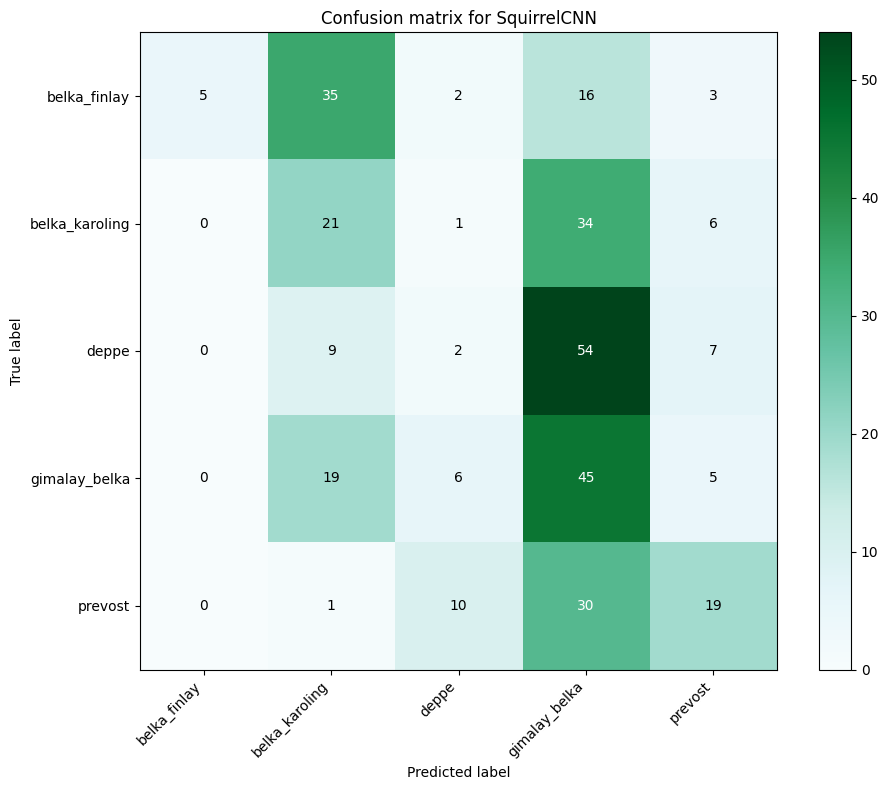

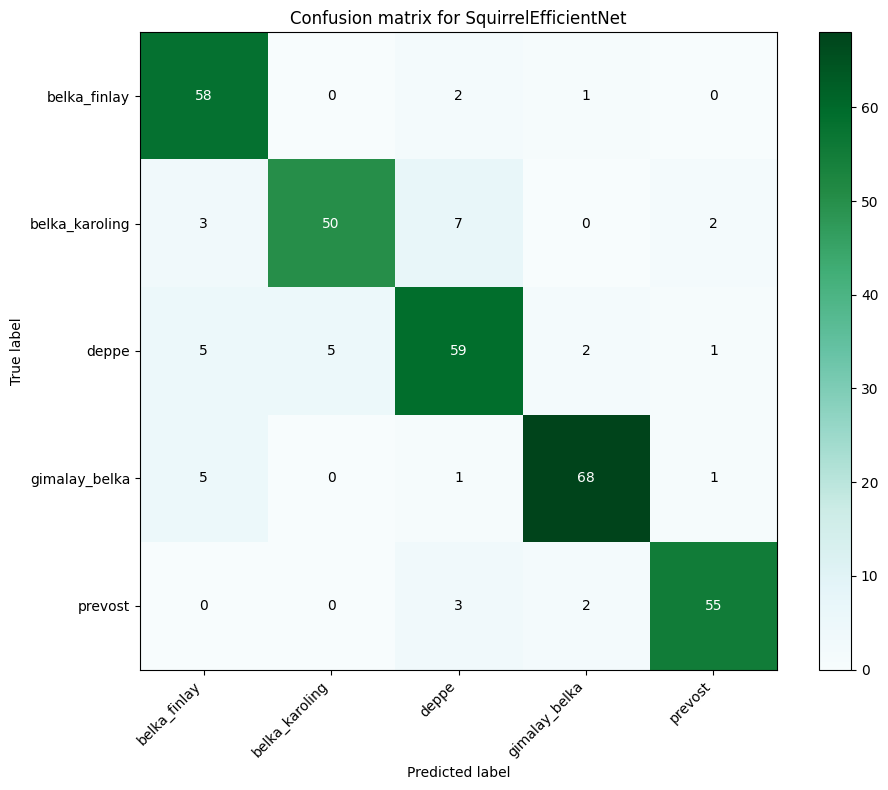

In [ ]:
class_names = testDataset.dataset.classes
for res in resultsList:
    plt.figure(figsize=(10,8))
    im = plt.imshow(res["confusionMatrix"], interpolation='nearest', cmap=plt.cm.BuGn)
    plt.title(f"Confusion matrix for {res['modelName']}")
    plt.colorbar(im)
    plt.xlabel("Predicted label")
    plt.ylabel("True label")
    plt.xticks(range(len(class_names)), class_names, rotation=45, ha='right')
    plt.yticks(range(len(class_names)), class_names)
    for i in range(res["confusionMatrix"].shape[0]):
        for j in range(res["confusionMatrix"].shape[1]):
            plt.text(j, i, res["confusionMatrix"][i, j], ha="center", va="center", color="white" if res["confusionMatrix"][i,j] > res["confusionMatrix"].max()/2 else "black")
    plt.tight_layout()
    plt.show()

ГРАФИЧЕСКИЙ ИНТЕРФЕЙС


In [ ]:
# squirrel_app.py (или в ячейке Jupyter)
import ipywidgets as widgets
from IPython.display import display, clear_output, HTML
import torch
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import io
import json
import os
import numpy as np
from datetime import datetime


class SquirrelClassifierApp:
    "Приложение для классификации белок с IPywidgets"
    
    def __init__(self):
        self.model = None
        self.class_names = []
        self.current_image = None
        self.history = []
        
        self.load_model()
        
        self.create_ui()
    
    def load_model(self, model_name="SquirrelEfficientNet"):
        try:
            model_path = f"{model_name}_weights.pth"
            info_path = f"{model_name}_info.json"
            
            if not os.path.exists(model_path):
                print(f"⚠️ Файл модели не найден: {model_path}")
                return False
            
            # Выбираем класс модели
            if model_name == "SquirrelEfficientNet":
                model_class = SquirrelEfficientNet
            elif model_name == "SquirrelCNN":
                model_class = SquirrelCNN
            else:
                print(f"⚠️ Неизвестная модель: {model_name}")
                return False
            
            if os.path.exists(info_path):
                with open(info_path, 'r', encoding='utf-8') as f:
                    info = json.load(f)
                self.class_names = info.get('classes', [])
                print(f"✅ Загружены классы: {self.class_names}")
            else:
                self.class_names = [f"Вид_{i}" for i in range(5)]
                print("⚠️ Используются классы по умолчанию")
            
            # Создаем и загружаем модель
            self.model = model_class(num_classes=len(self.class_names))
            self.model.load_state_dict(torch.load(model_path, map_location='cpu'))
            self.model.eval()
            
            print(f"✅ Модель {model_name} загружена")
            return True
            
        except Exception as e:
            print(f"❌ Ошибка загрузки модели: {e}")
            return False
    
    def create_ui(self):
        """Создание пользовательского интерфейса"""
        
        self.header = widgets.HTML(
            value="""
            <div style="background: linear-gradient(135deg, #667eea 0%, #764ba2 100%); 
                    padding: 20px; border-radius: 10px; color: white; text-align: center;">
                <h1 style="margin: 0;">🐿️ Классификатор видов белок</h1>
                <p style="margin: 5px 0 0 0; opacity: 0.9;">Нейросеть для определения видов белок по фотографии</p>
            </div>
            """
        )
        
        self.model_selector = widgets.Dropdown(
            options=['SquirrelEfficientNet'],
            value='SquirrelEfficientNet',
            description='Модель:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='300px')
        )
        
        self.btn_load_model = widgets.Button(
            description='🔄 Загрузить модель',
            button_style='info',
            tooltip='Загрузить выбранную модель',
            layout=widgets.Layout(width='200px')
        )
        
        self.model_info = widgets.Output()
        
        self.upload_btn = widgets.FileUpload(
            accept='image/*',
            multiple=False,
            description='📷 Загрузить фото',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='250px')
        )
        
        self.image_display = widgets.Image(
            format='jpeg',
            width=400,
            height=400,
            layout=widgets.Layout(border='2px solid #ddd', padding='10px')
        )
        
        self.image_info = widgets.HTML(value="<p>Изображение не загружено</p>")
        
        self.result_title = widgets.HTML(value="<h3>🎯 Результат классификации:</h3>")
        
        self.result_text = widgets.HTML(
            value="<div style='padding: 20px; background: #f5f5f5; border-radius: 5px;'>"
                  "<p style='color: #666; text-align: center;'>Загрузите изображение для классификации</p>"
                  "</div>"
        )
        
        self.confidence_bar = widgets.FloatProgress(
            value=0,
            min=0,
            max=100,
            description='Уверенность:',
            bar_style='info',
            style={'bar_color': '#4CAF50'},
            layout=widgets.Layout(width='80%')
        )
        
        self.confidence_value = widgets.Label(value="0%")
        
        self.results_table = widgets.Output()
        
        self.history_output = widgets.Output()
        
        self.btn_classify = widgets.Button(
            description='🔍 Классифицировать',
            button_style='success',
            disabled=True,
            layout=widgets.Layout(width='200px', height='40px')
        )
        
        self.btn_clear = widgets.Button(
            description='🗑️ Очистить',
            button_style='warning',
            layout=widgets.Layout(width='150px', height='40px')
        )
        
        self.btn_save_result = widgets.Button(
            description='💾 Сохранить результат',
            button_style='info',
            disabled=True,
            layout=widgets.Layout(width='200px', height='40px')
        )
        
        self.status_bar = widgets.HTML(
            value="<div style='padding: 10px; background: #e8f4fd; border-radius: 5px;'>"
                  "✅ Готов к работе. Загрузите модель и изображение."
                  "</div>"
        )
   
        model_panel = widgets.VBox([
            widgets.HTML("<h3>⚙️ Настройки модели</h3>"),
            widgets.HBox([self.model_selector, self.btn_load_model]),
            self.model_info
        ], layout=widgets.Layout(padding='10px', border='1px solid #ddd', margin='10px 0'))
        
        upload_panel = widgets.VBox([
            widgets.HTML("<h3>📁 Загрузка изображения</h3>"),
            self.upload_btn,
            self.image_display,
            self.image_info
        ], layout=widgets.Layout(padding='10px', border='1px solid #ddd', margin='10px 0'))
        
        results_panel = widgets.VBox([
            widgets.HTML("<h3>📊 Результаты</h3>"),
            self.result_title,
            self.result_text,
            widgets.HBox([self.confidence_bar, self.confidence_value]),
            widgets.HTML("<h4>📈 Все предсказания:</h4>"),
            self.results_table,
            widgets.HBox([self.btn_classify, self.btn_clear, self.btn_save_result])
        ], layout=widgets.Layout(padding='10px', border='1px solid #ddd', margin='10px 0'))
        
        history_panel = widgets.VBox([
            widgets.HTML("<h3>📜 История классификаций</h3>"),
            self.history_output
        ], layout=widgets.Layout(padding='10px', border='1px solid #ddd', margin='10px 0'))
        
        self.tab = widgets.Tab()
        self.tab.children = [upload_panel, results_panel, history_panel]
        self.tab.set_title(0, '📷 Изображение')
        self.tab.set_title(1, '📊 Результаты')
        self.tab.set_title(2, '📜 История')
        
        self.app = widgets.VBox([
            self.header,
            model_panel,
            self.tab,
            self.status_bar
        ])
        
        # ===== 11. НАСТРОЙКА ОБРАБОТЧИКОВ =====
        self.btn_load_model.on_click(self.on_load_model_click)
        self.upload_btn.observe(self.on_upload_change, names='value')
        self.btn_classify.on_click(self.on_classify_click)
        self.btn_clear.on_click(self.on_clear_click)
        self.btn_save_result.on_click(self.on_save_result_click)
        
        # Показать интерфейс
        display(self.app)
    
    def on_load_model_click(self, b):
        """Загрузка выбранной модели"""
        model_name = self.model_selector.value
        with self.model_info:
            clear_output()
            if self.load_model(model_name):
                print(f"✅ Модель {model_name} загружена успешно!")
                print(f"📊 Количество классов: {len(self.class_names)}")
                print(f"📋 Классы: {', '.join(self.class_names[:3])}...")
            else:
                print(f"❌ Не удалось загрузить модель {model_name}")
    
    def on_upload_change(self, change):
        """Обработка загрузки изображения"""
        if self.upload_btn.value:
            uploaded = list(self.upload_btn.value.values())[0]
            self.current_image = uploaded['content']
            
            self.image_display.value = self.current_image
            
            img = Image.open(io.BytesIO(self.current_image))
            self.image_info.value = f"""
            <p><strong>📄 Файл:</strong> {list(self.upload_btn.value.keys())[0]}</p>
            <p><strong>📏 Размер:</strong> {img.width} × {img.height} px</p>
            <p><strong>🎨 Формат:</strong> {img.format}</p>
            """
            
            self.btn_classify.disabled = False
            self.btn_save_result.disabled = True
            
            self.update_status("✅ Изображение загружено. Нажмите 'Классифицировать'")
    
    def on_classify_click(self, b):
        """Классификация изображения"""
        if not self.current_image or not self.model:
            self.update_status("❌ Сначала загрузите модель и изображение")
            return
        
        self.btn_classify.disabled = True
        self.btn_classify.description = "⏳ Обработка..."
        
        try:
            image = Image.open(io.BytesIO(self.current_image)).convert('RGB')
            
            transform = transforms.Compose([
                transforms.Resize(int(224 * 1.14)),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ])
            
            input_tensor = transform(image).unsqueeze(0)
            
            with torch.no_grad():
                outputs = self.model(input_tensor)
                probabilities = F.softmax(outputs, dim=1)
                top_probs, top_indices = torch.topk(probabilities, k=min(5, len(self.class_names)))
            
            results = []
            for i in range(len(top_indices[0])):
                class_idx = top_indices[0][i].item()
                confidence = top_probs[0][i].item() * 100
                class_name = self.class_names[class_idx] if class_idx < len(self.class_names) else f"Class_{class_idx}"
                results.append({
                    'rank': i + 1,
                    'class': class_name,
                    'confidence': confidence
                })
            
            # Сохраняем в историю
            self.history.append({
                'timestamp': datetime.now().strftime("%H:%M:%S"),
                'results': results,
                'image_size': image.size
            })
            
            # Обновляем интерфейс
            self.update_results(results, image.size)
            self.update_history()
            
            # Активируем кнопку сохранения
            self.btn_save_result.disabled = False
            
            self.update_status("✅ Классификация завершена успешно!")
            
        except Exception as e:
            self.update_status(f"❌ Ошибка классификации: {str(e)}")
        finally:
            self.btn_classify.disabled = False
            self.btn_classify.description = "🔍 Классифицировать"
    
    def update_results(self, results, image_size):
        """Обновление результатов на интерфейсе"""
        main_result = results[0]
        
        if main_result['confidence'] > 85:
            color = "#4CAF50"
            emoji = "🎯"
            confidence_level = "Высокая уверенность"
        elif main_result['confidence'] > 60:
            color = "#FF9800"
            emoji = "🔍"
            confidence_level = "Средняя уверенность"
        else:
            color = "#F44336"
            emoji = "⚠️"
            confidence_level = "Низкая уверенность"
        
        self.result_text.value = f"""
        <div style="padding: 20px; background: {color}10; border-left: 5px solid {color}; border-radius: 5px;">
            <h2 style="color: {color}; margin: 0 0 10px 0;">
                {emoji} {main_result['class']}
            </h2>
            <p><strong>Уровень уверенности:</strong> {confidence_level}</p>
            <p><strong>Размер изображения:</strong> {image_size[0]} × {image_size[1]} px</p>
        </div>
        """
        
        self.confidence_bar.value = main_result['confidence']
        self.confidence_bar.style = {'bar_color': color}
        self.confidence_value.value = f"{main_result['confidence']:.1f}%"
        
        with self.results_table:
            clear_output()
            
            table_html = """
            <style>
            .results-table {
                width: 100%;
                border-collapse: collapse;
                margin: 10px 0;
            }
            .results-table th {
                background: linear-gradient(135deg, #667eea 0%, #764ba2 100%);
                color: white;
                padding: 12px;
                text-align: left;
            }
            .results-table td {
                padding: 10px;
                border-bottom: 1px solid #ddd;
            }
            .results-table tr:nth-child(even) {
                background-color: #f9f9f9;
            }
            .confidence-bar {
                height: 10px;
                background: #e0e0e0;
                border-radius: 5px;
                overflow: hidden;
            }
            .confidence-fill {
                height: 100%;
                border-radius: 5px;
            }
            </style>
            
            <table class="results-table">
            <tr>
                <th>#</th>
                <th>Вид белки</th>
                <th>Уверенность</th>
                <th>Визуализация</th>
            </tr>
            """
            
            for result in results:
                rank = result['rank']
                class_name = result['class']
                confidence = result['confidence']
                
                if confidence > 80:
                    bar_color = "#4CAF50"
                elif confidence > 50:
                    bar_color = "#FF9800"
                else:
                    bar_color = "#F44336"
                
                table_html += f"""
                <tr>
                    <td><strong>{rank}</strong></td>
                    <td>{class_name}</td>
                    <td><strong>{confidence:.1f}%</strong></td>
                    <td style="width: 200px;">
                        <div class="confidence-bar">
                            <div class="confidence-fill" style="width: {confidence}%; background: {bar_color};"></div>
                        </div>
                    </td>
                </tr>
                """
            
            table_html += "</table>"
            
            table_html += f"""
            <div style="margin-top: 20px; padding: 15px; background: #f5f5f5; border-radius: 5px;">
                <p><strong>📊 Статистика:</strong></p>
                <p>• Лучшее предсказание: <strong>{results[0]['confidence']:.1f}%</strong></p>
                <p>• Средняя уверенность топ-3: <strong>{sum(r['confidence'] for r in results[:3])/3:.1f}%</strong></p>
                <p>• Количество классов: <strong>{len(results)}</strong></p>
            </div>
            """
            
            display(HTML(table_html))
    
    def update_history(self):
        """Обновление истории классификаций"""
        with self.history_output:
            clear_output()
            
            if not self.history:
                print("История пуста")
                return
            
            history_html = """
            <style>
            .history-item {
                background: #f9f9f9;
                padding: 15px;
                margin: 10px 0;
                border-left: 4px solid #4CAF50;
                border-radius: 5px;
            }
            .history-time {
                color: #666;
                font-size: 0.9em;
            }
            </style>
            """
            
            # Показываем последние 5 записей
            for entry in self.history[-5:]:
                main_result = entry['results'][0]
                
                history_html += f"""
                <div class="history-item">
                    <p class="history-time">⏰ {entry['timestamp']} | 📏 {entry['image_size'][0]}×{entry['image_size'][1]}</p>
                    <p><strong>🎯 {main_result['class']}</strong> - {main_result['confidence']:.1f}%</p>
                </div>
                """
            
            display(HTML(history_html))
    
    def on_clear_click(self, b):
        """Очистка интерфейса"""
        self.current_image = None
        self.image_display.value = b''
        self.image_info.value = "<p>Изображение не загружено</p>"
        self.result_text.value = "<p>Загрузите изображение для классификации</p>"
        self.confidence_bar.value = 0
        self.confidence_value.value = "0%"
        self.btn_classify.disabled = True
        self.btn_save_result.disabled = True
        
        with self.results_table:
            clear_output()
        
        self.update_status("✅ Интерфейс очищен")
    
    def on_save_result_click(self, b):
        """Сохранение результатов"""
        if not self.history:
            self.update_status("❌ Нет результатов для сохранения")
            return
        
        try:
            # Сохраняем последний результат
            last_result = self.history[-1]
            filename = f"result_{datetime.now().strftime('%Y%m%d_%H%M%S')}.txt"
            
            with open(filename, 'w', encoding='utf-8') as f:
                f.write("="*50 + "\n")
                f.write("РЕЗУЛЬТАТ КЛАССИФИКАЦИИ БЕЛКИ\n")
                f.write("="*50 + "\n\n")
                f.write(f"Дата: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}\n")
                f.write(f"Модель: {self.model_selector.value}\n")
                f.write(f"Изображение: {list(self.upload_btn.value.keys())[0] if self.upload_btn.value else 'Неизвестно'}\n")
                f.write(f"Размер: {last_result['image_size'][0]} × {last_result['image_size'][1]} px\n\n")
                
                f.write("РЕЗУЛЬТАТЫ:\n")
                f.write("-"*50 + "\n")
                
                for result in last_result['results']:
                    f.write(f"{result['rank']}. {result['class']}: {result['confidence']:.1f}%\n")
            
            self.update_status(f"✅ Результат сохранен в файл: {filename}")
            
        except Exception as e:
            self.update_status(f"❌ Ошибка сохранения: {str(e)}")
    
    def update_status(self, message):
        """Обновление статус-бара"""
        timestamp = datetime.now().strftime("%H:%M:%S")
        self.status_bar.value = f"""
        <div style='padding: 10px; background: #e8f4fd; border-radius: 5px; border-left: 4px solid #2196F3;'>
            <strong>[{timestamp}]</strong> {message}
        </div>
        """

In [ ]:
# Простой тест виджетов
import ipywidgets as widgets
from IPython.display import display

print("🧪 Тестирую виджеты...")

# Создаем простую кнопку
test_button = widgets.Button(description="Нажми меня")
test_output = widgets.Output()

def on_button_click(b):
    with test_output:
        print("✅ Кнопка работает!")

test_button.on_click(on_button_click)

# Пытаемся отобразить
try:
    display(widgets.VBox([test_button, test_output]))
    print("🎉 Виджеты отображаются!")
except Exception as e:
    print(f"❌ Ошибка отображения виджетов: {e}")

In [ ]:
import ipywidgets as widgets
import ipykernel
import sys

print(f"Python: {sys.version}")
print(f"ipywidgets: {widgets.__version__}")
print(f"ipykernel: {ipykernel.__version__}")

# Проверка доступных виджетов
print("\nДоступные виджеты:")
print(dir(widgets)[:20])  # первые 20 виджетов

In [ ]:
print("lol")

In [ ]:
app = SquirrelClassifierApp()
display(app)

✅ Загружены классы: ['belka_finlay', 'belka_karoling', 'deppe', 'gimalay_belka', 'prevost']
✅ Модель SquirrelEfficientNet загружена
